In [ ]:
import os

from Speechbrain import identify_language
from OWSM import owsm_detect_language_from_array, file_to_array

import langcodes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtrans

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import f_oneway, pearsonr, ttest_ind_from_stats

import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [ ]:
RECORDINGS_DIR = os.path.join("archive", "recordings")
METADATA_CSV = os.path.join("archive", "speakers_all.csv")
PROGRESS_FILE = "progress.csv"

# Load and Clean Data

In [122]:
df = pd.read_csv(METADATA_CSV)
df = df.drop(columns=[col for col in df.columns if "Unnamed" in col])
df['filename'] = df['filename'].apply(lambda x: x + ".mp3")
df["file_missing?"] = ~df['filename'].isin(os.listdir(RECORDINGS_DIR))
df = df[~df["file_missing?"] & ~df["native_language"].isin(["synthesized", "teochew"])]
df["native_language"] = df["native_language"].apply(lambda x: langcodes.standardize_tag(str(langcodes.find(x.replace("agni", "Anyin").replace("amazigh", "Berber languages").replace("ashanti", "Akan").replace("bafang", "Fe'fe'").replace("baga", "Baga Sitemu").replace("chaldean", "Chaldean Neo-Aramaic").replace("hainanese", "Unknown language [hnm]").replace("ife", "Ifè").replace("kru", "Kru languages").replace("lamotrekese", "Woleaian").replace("nicaragua", "Unknown language [ni]").replace("taishan", "Tsuvan").replace("xasonga", "Xaasongaxango")).language)))
df["spoken_language"] = "en"
df = df.reset_index().drop(columns=["index"])
df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,spoken_language
0,27.0,9.0,"virginia, south africa",afrikaans1.mp3,af,female,1,south africa,False,en
1,40.0,5.0,"pretoria, south africa",afrikaans2.mp3,af,male,2,south africa,False,en
2,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3.mp3,af,male,418,south africa,False,en
3,26.0,8.0,"pretoria, south africa",afrikaans4.mp3,af,male,1159,south africa,False,en
4,19.0,6.0,"cape town, south africa",afrikaans5.mp3,af,male,1432,south africa,False,en


In [ ]:
if os.path.exists(PROGRESS_FILE):
    df_progress = pd.read_csv(PROGRESS_FILE)
    processed_ids = set(idx for idx, _ in df_progress.iterrows())
else:
    df_progress = pd.DataFrame()
    processed_ids = set()

In [212]:
df_progress.tail()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,spoken_language,speechbrain_predicted_language,owsm_predicted_language
2130,47.0,2.0,"ibadan, nigeria",yoruba5.mp3,yo,female,2023,nigeria,False,en,en,en
2131,31.0,1.0,"bethel, alaska, usa",yupik1.mp3,esu,female,571,usa,False,en,en,en
2132,24.0,14.0,"bulawayo, zimbabwe",zulu1.mp3,zu,female,406,zimbabwe,False,en,en,en
2133,33.0,10.0,"drammen, norway",norwegian1.mp3,no,female,272,norway,False,en,en,en
2134,55.0,12.0,"oslo, norway",norwegian2.mp3,no,female,273,norway,False,en,en,en


# Run Language Identification

In [213]:
# Process and save row-by-row
CHECK_IF_NEW_COLUMNS = False
for idx, row in df.iterrows():
    if not CHECK_IF_NEW_COLUMNS and idx in processed_ids:
        continue

    if idx in processed_ids:
        processed_row = df_progress.loc[idx].copy() # type: ignore
    else:
        processed_row = row.copy()

    array = file_to_array(os.path.join(RECORDINGS_DIR, row["filename"]))
    if pd.isna(processed_row.get("speechbrain_predicted_language")):
        processed_row["speechbrain_predicted_language"] = identify_language(array)
    if pd.isna(processed_row.get("owsm_predicted_language")):
        processed_row["owsm_predicted_language"] = owsm_detect_language_from_array(array)

    df_progress.loc[idx] = processed_row # type: ignore
    if idx in processed_ids:
        df_progress.to_csv(PROGRESS_FILE, index=False, header=True)
    else:
        # Append to file
        pd.DataFrame([processed_row]).to_csv(PROGRESS_FILE, mode='a', index=False, header=not os.path.exists(PROGRESS_FILE))

    print(f"Processed Row: {idx}")

# Visualize Results

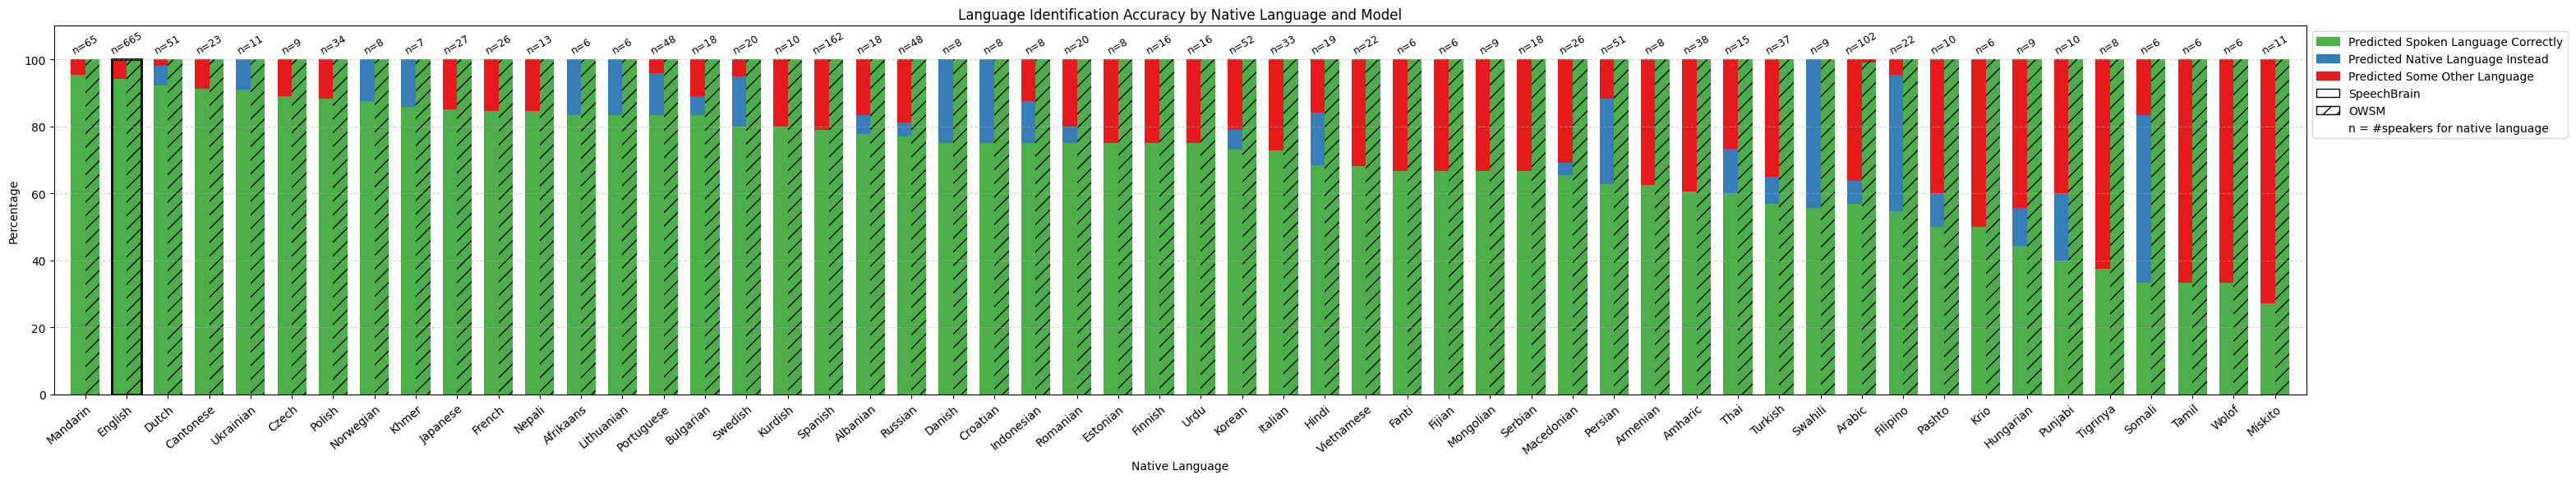

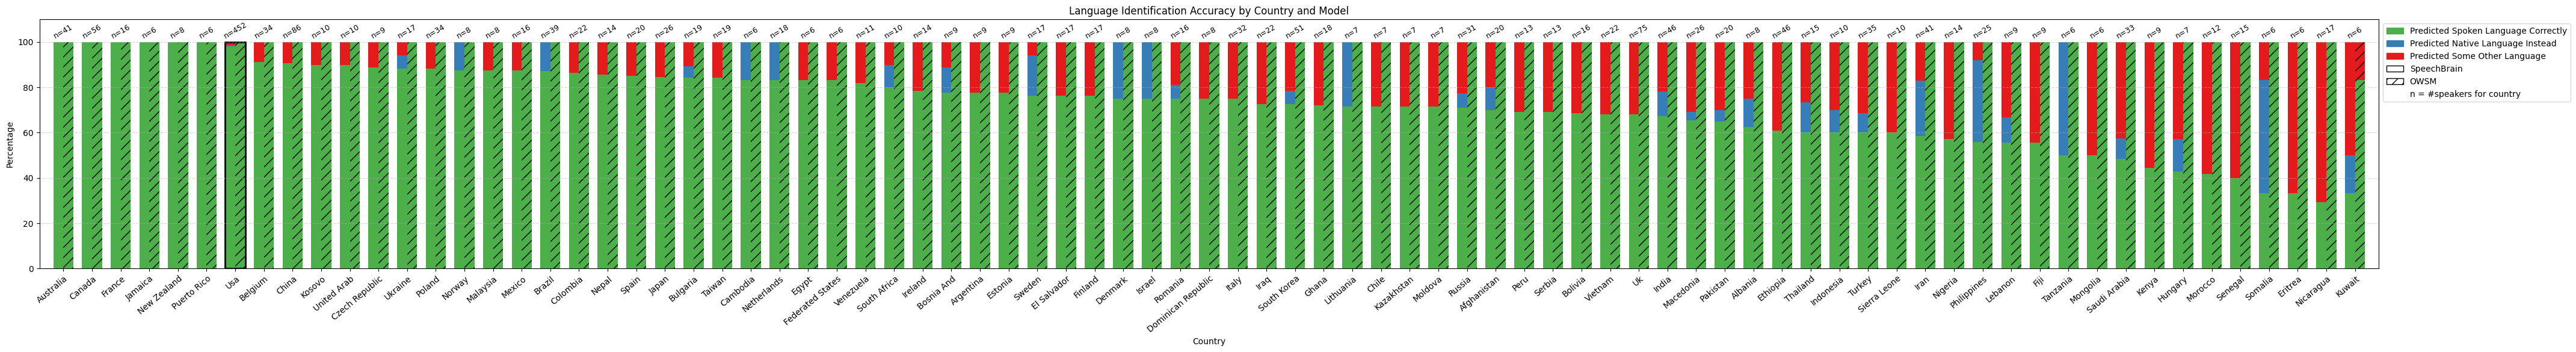

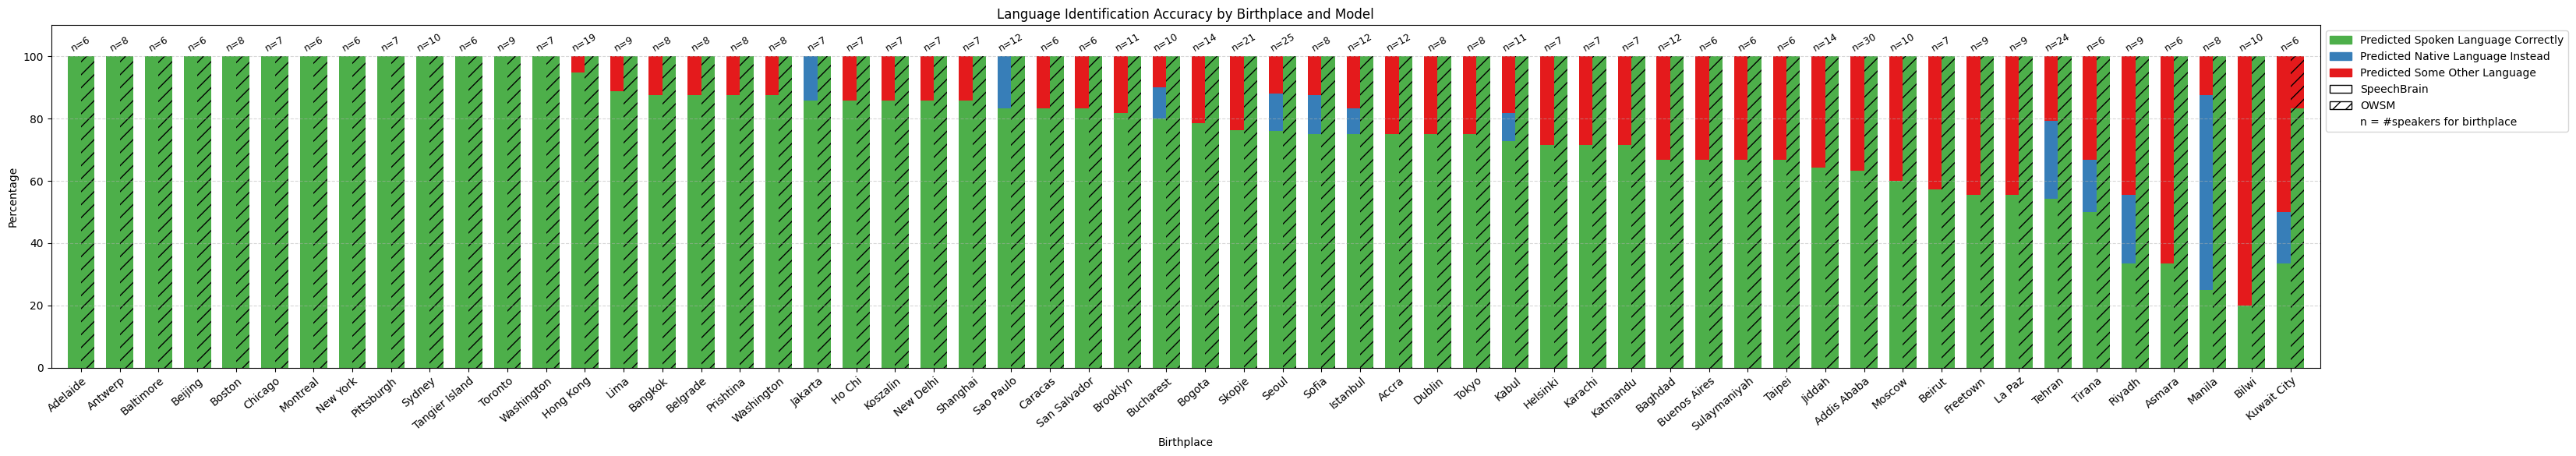

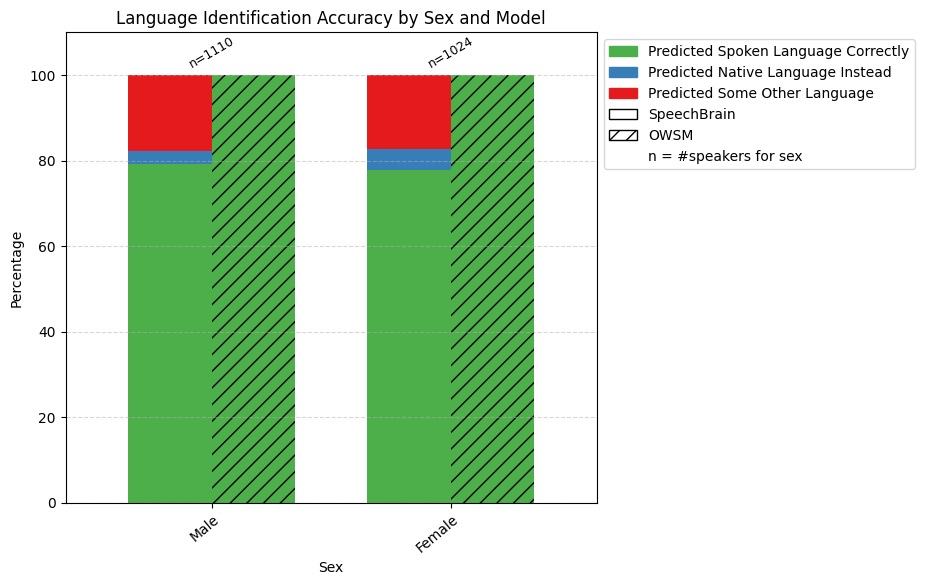

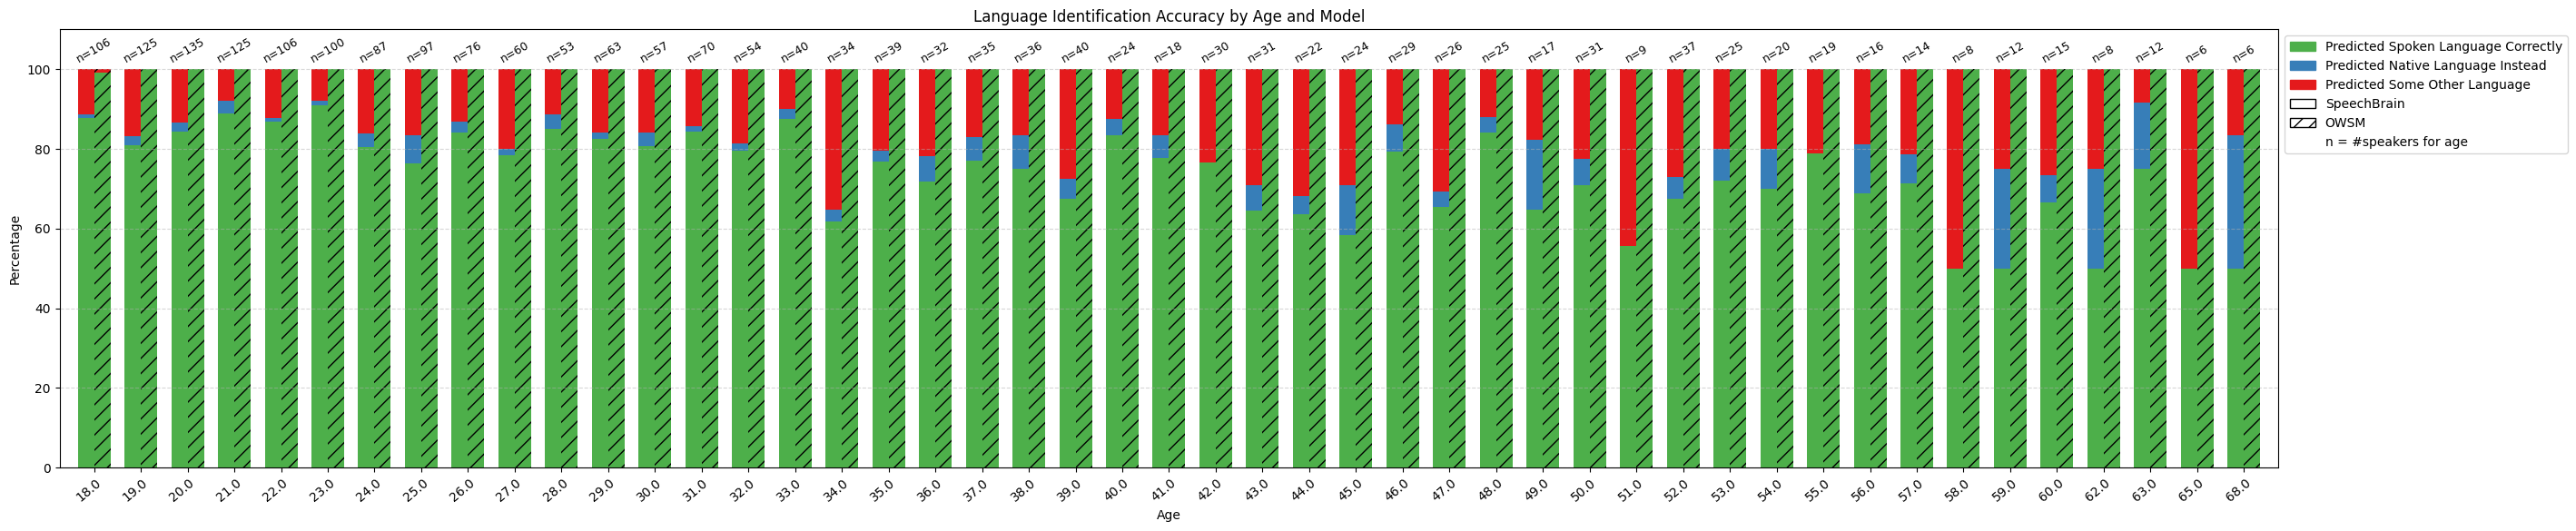

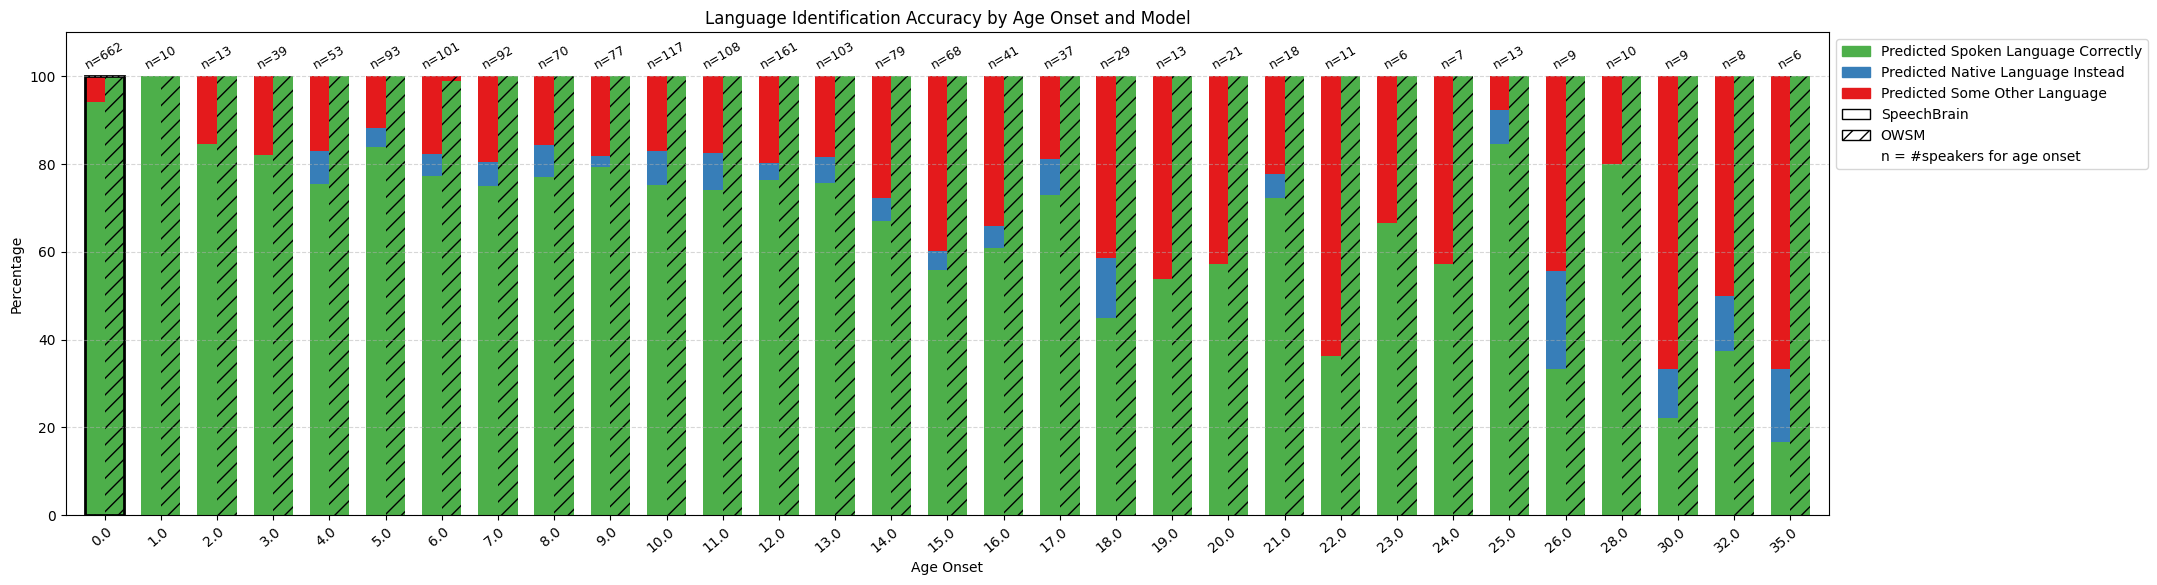

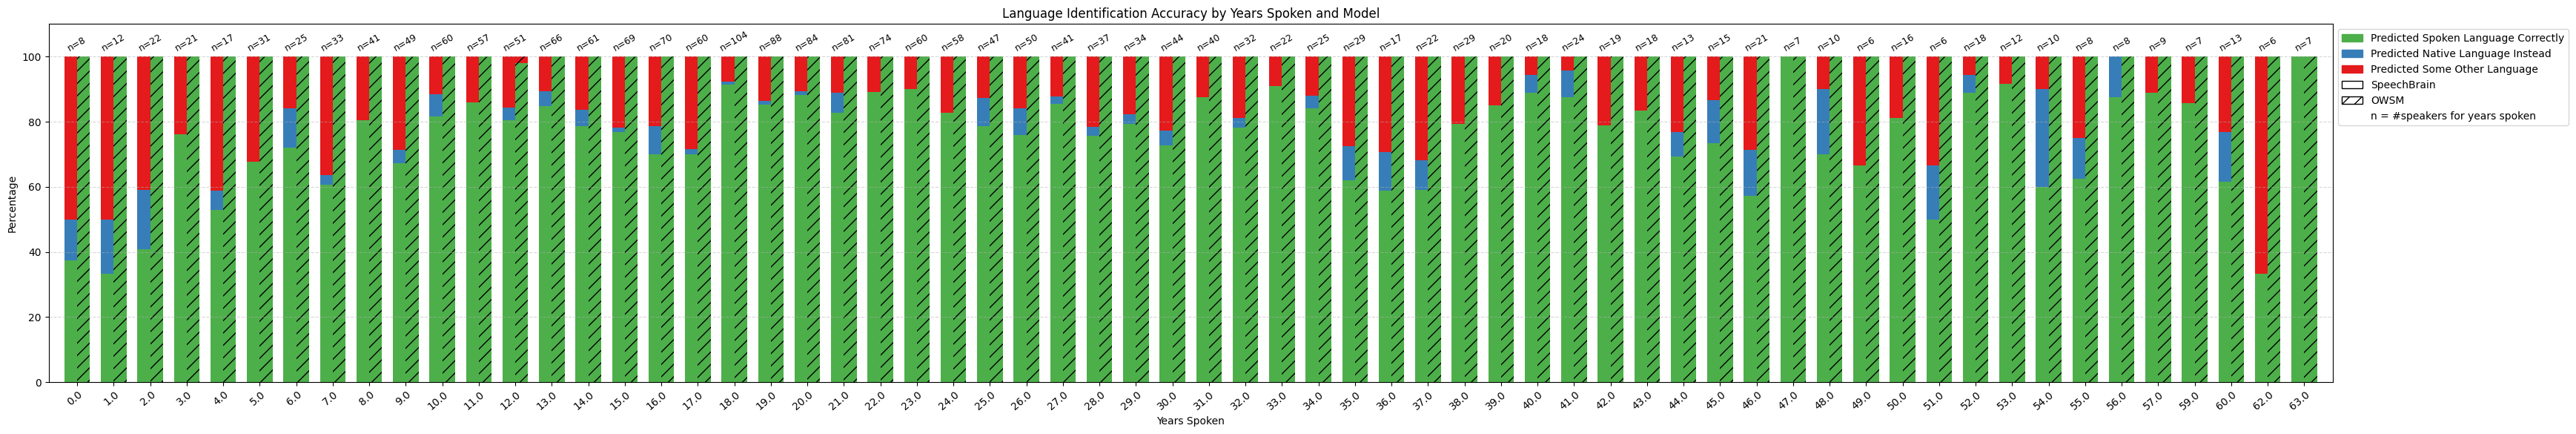

In [371]:
df_progress['years_spoken'] = df_progress['age'] - df_progress['age_onset']

for group_by_column, highlight_value, sort in [
    ('native_language', 'en', 'score'),
    ('country', 'usa', 'score'),
    ('birthplace', None, 'score'),
    ('sex', None, 'score'),
    ('age', None, 'sequential'),
    ('age_onset', 0.0, 'sequential'),
    ('years_spoken', None, 'sequential')
]:
    def capitalize(string):
        return ' '.join(map(lambda x: x.capitalize(), string.replace("_", " ").split(" ")))

    def compute_accuracies(df, model_col):
        results = []
        for native_lang in df[group_by_column].unique():
            subset = df[df[group_by_column] == native_lang]
            total = len(subset)
            if total <= 5: # only include n > 5
                continue

            spoken_correct = (subset[model_col] == subset['spoken_language']).sum()
            native_correct = ((subset[model_col] == subset['native_language']) & (subset[model_col] != subset['spoken_language'])).sum()
            inaccurate = total - spoken_correct - native_correct

            results.append({
                group_by_column: native_lang,
                'model': model_col,
                'spoken_accuracy': spoken_correct / total * 100,
                'native_accuracy': native_correct / total * 100,
                'inaccuracy': inaccurate / total * 100
            })
        return pd.DataFrame(results)

    # Compute for both models
    speechbrain_results = compute_accuracies(df_progress, 'speechbrain_predicted_language')
    owsm_results = compute_accuracies(df_progress, 'owsm_predicted_language')
    result_df = pd.concat([speechbrain_results, owsm_results])

    # Rename models
    result_df['model'] = result_df['model'].map({
        'speechbrain_predicted_language': 'SpeechBrain',
        'owsm_predicted_language': 'OWSM'
    })

    if sort == "score":
        # sort native languages by average model accuracy, break ties by native_accuracy, then alphabetical
        result_df['avg_accuracy'] = result_df['spoken_accuracy'] + result_df['native_accuracy'] / len(result_df)
        avg_acc_by_native = result_df.groupby(group_by_column)['avg_accuracy'].mean()
        avg_acc_by_native = avg_acc_by_native.reset_index().sort_values(
            by=['avg_accuracy', group_by_column], 
            ascending=[False, True]
        )
        native_languages = avg_acc_by_native[group_by_column].tolist()
    else:
        native_languages = sorted(result_df[group_by_column].unique())

    # Plotting
    fig, ax = plt.subplots(figsize=(len(native_languages) / 2 + 10, 7))

    bar_width = 0.35
    x = np.arange(len(native_languages))
    model_offset = {'SpeechBrain': -bar_width/2, 'OWSM': bar_width/2}
    patterns = {'SpeechBrain': '', 'OWSM': '//'}
    colors = ['#4daf4a', '#377eb8', '#e41a1c']  # spoken, native, inaccuracy

    for i, native_lang in enumerate(native_languages):
        for model in ['SpeechBrain', 'OWSM']:
            row = result_df[(result_df[group_by_column] == native_lang) & (result_df['model'] == model)].iloc[0]
            bottom = 0
            for j, (metric, color) in enumerate(zip(['spoken_accuracy', 'native_accuracy', 'inaccuracy'], colors)):
                value = row[metric]
                ax.bar(x[i] + model_offset[model], value, bar_width,
                    bottom=bottom, color=color, label=metric if i == 0 and model == 'SpeechBrain' else "",
                    hatch=patterns[model])
                bottom += value

    # Legends
    metric_legend = [
        mpatches.Patch(color=colors[0], label='Predicted Spoken Language Correctly'),
        mpatches.Patch(color=colors[1], label='Predicted Native Language Instead'),
        mpatches.Patch(color=colors[2], label='Predicted Some Other Language')
    ]
    pattern_legend = [
        mpatches.Patch(facecolor='white', edgecolor='black', hatch='', label='SpeechBrain'),
        mpatches.Patch(facecolor='white', edgecolor='black', hatch='//', label='OWSM')
    ]
    sample_legend = [
        mpatches.Patch(facecolor='none', edgecolor='none', label=f'n = #speakers for {group_by_column.replace("_", " ")}')
    ]

    # ax.legend(handles=metric_legend + pattern_legend, loc='upper right')
    ax.legend(handles=metric_legend + pattern_legend + sample_legend, bbox_to_anchor=(1, 1), loc='upper left')
    ax.set_xticks(x)
    if group_by_column == 'native_language':
        ax.set_xticklabels([langcodes.Language(l).language_name().split(" ")[0] for l in native_languages], ha='right', va='top', rotation=40)
    else:
        ax.set_xticklabels([capitalize(' '.join(str(n).split(" ")[:2])) if len(str(n).split(" ")) > 2 else capitalize(str(n)) for n in [str(m).split(",")[0] for m in native_languages]], ha='right', va='top', rotation=40)
    pixels_to_shift_xticks_right_by = 10
    for t in ax.get_xticklabels():
        t.set_transform(t.get_transform() + mtrans.Affine2D().translate(pixels_to_shift_xticks_right_by, 0))
    to_remove = 0.0471761 * len(native_languages) - 0.270515
    ax.set_xlim((ax.get_xlim()[0] + to_remove, ax.get_xlim()[1] - to_remove))
    ax.set_xlabel(capitalize(group_by_column))
    ax.set_ylabel("Percentage")
    ax.set_title(f"Language Identification Accuracy by {capitalize(group_by_column)} and Model")

    # Annotate sample size below x-axis labels
    for i, native_lang in enumerate(native_languages):
        n_samples = df_progress[df_progress[group_by_column] == native_lang].shape[0]
        ax.text(x[i], 101, f"n={n_samples}", ha='center', va='bottom', fontsize=9, rotation=30)
    ax.set_ylim(top=110)

    # Draw rectangle around English bars
    if highlight_value in native_languages:
        english_index = native_languages.index(highlight_value)
        center = x[english_index]
        left = center - bar_width
        right = center + bar_width
        top = 100  # assuming percent scale
        ax.add_patch(plt.Rectangle((left, 0), (right - left), top,
                                fill=False, edgecolor='black', linewidth=2, linestyle='-'))

    plt.tight_layout(rect=(0.0, 0.0, 0.85, 0.85))
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.show()

# Qualitative Analysis

In [340]:
[langcodes.Language(s).language_name() for s in result_df[result_df['native_accuracy'] > result_df['inaccuracy']]['native_language'].unique()]

['Afrikaans',
 'Croatian',
 'Danish',
 'Persian',
 'Dutch',
 'Filipino',
 'Khmer',
 'Swahili',
 'Lithuanian',
 'Norwegian',
 'Portuguese',
 'Somali',
 'Swedish',
 'Ukrainian']

In [374]:
df_progress[(df_progress['speechbrain_predicted_language'] != df_progress['spoken_language']) & (df_progress['speechbrain_predicted_language'] == df_progress['native_language'])]

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,spoken_language,speechbrain_predicted_language,owsm_predicted_language,years_spoken,accuracy,spoken_accuracy
0,27.0,9.0,"virginia, south africa",afrikaans1.mp3,af,female,1,south africa,False,en,af,en,18.0,50,False
9,44.0,35.0,"tirana, albania",albanian3.mp3,sq,male,458,albania,False,en,sq,en,9.0,50,False
70,38.0,12.0,"riyadh, saudi arabia",arabic1.mp3,ar,female,11,saudi arabia,False,en,ar,en,26.0,50,False
75,30.0,14.0,"monastir, tunisia",arabic11.mp3,ar,female,13,tunisia,False,en,ar,en,16.0,50,False
77,25.0,15.0,"zabbougha, lebanon",arabic13.mp3,ar,male,15,lebanon,False,en,ar,en,10.0,50,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,25.0,18.0,"istanbul, turkey",turkish19.mp3,tr,male,971,turkey,False,en,tr,en,7.0,50,False
2029,24.0,11.0,"diyarbakir, turkey",turkish32.mp3,tr,male,2033,turkey,False,en,tr,en,13.0,50,False
2031,24.0,11.0,"diyarbakir, turkey",turkish34.mp3,tr,male,2035,turkey,False,en,tr,en,13.0,50,False
2050,53.0,44.0,"akhtyrka, ukraine",ukrainian2.mp3,uk,female,844,ukraine,False,en,uk,en,9.0,50,False


# Statistical Analysis

In [375]:
# define accuracy
df_progress['accuracy'] = np.where(
    df_progress['speechbrain_predicted_language'] == df_progress['spoken_language'], 100,
    np.where(df_progress['speechbrain_predicted_language'] == df_progress['native_language'], 50, 0)
)
df_progress['spoken_accuracy'] = np.where(df_progress['speechbrain_predicted_language'] == df_progress['spoken_language'], 100, 0)

In [ ]:
# see if there is a statistical significant difference between native and non-native language identification accuracy
nat_mean, nat_std = df_progress[df_progress['native_language'] == 'en']['spoken_accuracy'].agg(func=['mean', 'std'])
print("Native accuracy", nat_mean, nat_std)
non_mean, non_std = df_progress[df_progress['native_language'] != 'en']['spoken_accuracy'].agg(func=['mean', 'std'])
print("Non-native accuracy", non_mean, non_std)

t_stat, p_value = ttest_ind_from_stats(
    mean1=nat_mean, std1=nat_std, nobs1=sum(df_progress['native_language'] == 'en'),
    mean2=non_mean, std2=non_std, nobs2=sum(df_progress['native_language'] != 'en'),
    equal_var=False  # Use Welch's t-test if variances are not assumed equal
)

print(f"t-statistic: {t_stat:.4}")
print(f"p-value: {p_value:.4e}")

Native accuracy 94.13533834586467 23.513896799426607
Non-native accuracy 71.29251700680273 45.255076308779564
t-statistic: 15.32
p-value: 2.8878e-50


: 

In [247]:
# --- 1. Correlation for numerical variables ---
numerical_cols = ['age', 'age_onset', 'years_spoken']
correlations = {col: pearsonr(df_progress[col], df_progress['accuracy']) for col in numerical_cols}
correlation_df = pd.DataFrame({
    'feature': list(correlations.keys()),
    'correlation': [c[0] for c in correlations.values()],
    'p_value': [c[1] for c in correlations.values()]
})
display(correlation_df)

,feature,correlation,p_value
0,age,-0.167609,6.428400e-15
1,age_onset,-0.321316,1.801977e-52
2,years_spoken,0.020082,3.536789e-01


In [276]:
# --- 2. ANOVA for categorical variables ---
categorical_cols = ['birthplace', 'native_language', 'sex', 'country']
anova_results = []
for col in categorical_cols + numerical_cols:
    groups = [df_progress[df_progress[col] == val]['accuracy'] for val in df_progress[col].unique() if sum(df_progress[col] == val) > 5]
    f_stat, p_val = f_oneway(*groups)
    anova_results.append({'feature': col, 'f_statistic': f_stat, 'p_value': p_val})
anova_df = pd.DataFrame(anova_results)
display(anova_df)

,feature,f_statistic,p_value
0,birthplace,1.906002,1.622916e-04
1,native_language,5.817325,3.177356e-34
2,sex,0.046140,8.299414e-01
3,country,5.198863,4.068922e-41
4,age,1.887374,3.256699e-04
5,age_onset,8.375318,2.337039e-34
6,years_spoken,2.338022,4.028885e-08


In [256]:
# --- 3. Feature importance using Random Forest ---
all_features = numerical_cols + categorical_cols
X = df_progress[all_features]
y = df_progress['accuracy']
X_encoded = pd.get_dummies(X, drop_first=True)

rf = RandomForestRegressor(random_state=0)
rf.fit(X_encoded, y)
feature_importances = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)
display(feature_importances.head(10))

,feature,importance
1,age_onset,0.139491
0,age,0.102695
2,years_spoken,0.083605
1506,country_usa,0.027084
1347,sex_female,0.012855
1348,sex_male,0.012175
1181,native_language_ar,0.012043
1451,country_nicaragua,0.007158
1368,country_botswana,0.006025
1178,native_language_am,0.005842


In [ ]:
# --- 4. Linear regression model: full vs native_language only ---
# Full model
test_df = result_df[result_df['model'] == 'SpeechBrain']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)
model_full = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
scores_full = cross_val_score(model_full, X, y, cv=5, scoring='r2')

# Native language only model
X_native = df_progress[['native_language']]
preprocessor_native = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['native_language'])
    ]
)
model_native = Pipeline(steps=[
    ('preprocessor', preprocessor_native),
    ('regressor', LinearRegression())
])
scores_native = cross_val_score(model_native, X_native, y, cv=5, scoring='r2')

print('Full Model Mean Abs R²:', scores_full.mean())
print('Native Language Only Mean R²:', scores_native.mean())


Full Model Mean Abs R²: -0.04319965077992623
Native Language Only Mean R²: -0.4535488787181454


In [282]:
# try with XGBoost pipeline
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=0, n_estimators=100, verbosity=0))
])
model_native_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_native),
    ('regressor', XGBRegressor(random_state=0, n_estimators=100, verbosity=0))
])

# Run cross-validation again with XGBoost models
scores_full_xgb = cross_val_score(model_xgb, X, y, cv=5, scoring='r2')
scores_native_xgb = cross_val_score(model_native_xgb, X_native, y, cv=5, scoring='r2')
{
    'XGBoost Full Model Mean R²': scores_full_xgb.mean(),
    'XGBoost Native Language Only Mean R²': scores_native_xgb.mean()
}

{'XGBoost Full Model Mean R²': 0.0865323781967163,
 'XGBoost Native Language Only Mean R²': 0.012983143329620361}